In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2022-11-16 17:25:00.233872: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


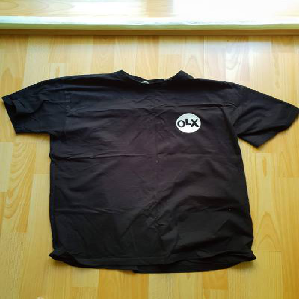

In [3]:
from tensorflow.keras.preprocessing.image import load_img

path = '../data/clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
# Reshaping image to the size the neural network will use
load_img(fullname, target_size=(299, 299))

As our first example, we are going to use a pretrained model.

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

model = Xception(
                weights='imagenet',
                input_shape=(299, 299, 3)
                )

2022-11-16 17:25:02.047879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:25:02.054925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:25:02.055623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:25:02.056430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Let's test this model on the image we've loaded previously.

In [5]:
img = load_img(fullname, target_size=(299, 299))
x = np.array(img)
x.shape

(299, 299, 3)

It's shape is (299, 299, 3) and contains three dimensions:
- The width of the image: 299
- The height of the image: 299
- The number of channels: red, green, blue

However, the model doesn’t expect to get just a single image. It gets a batch of images — several images put together in one array. This array should have four dimensions:
- The number of images
- The width
- The height
- The number of channels

Thus, we must create a new dimension:

In [6]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

Now, we preprocess the image before inputting it to the model, by converting the array integers in the range between 0 to 255 to the range [-1,1].

In [7]:
X = preprocess_input(X)

Now, we can make a prediction.

In [8]:
pred = model.predict(X)
print(pred.shape)
pred[0, :10]

2022-11-16 17:25:05.320844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-16 17:25:06.022443: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-16 17:25:06.023339: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-16 17:25:06.023380: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-16 17:25:06.024277: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-16 17:25:06.024364: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step
(1, 1000)


array([0.0003238 , 0.00015736, 0.00021406, 0.00015296, 0.00024657,
       0.00030446, 0.00032349, 0.00014726, 0.00020487, 0.00014866],
      dtype=float32)

In [9]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.6792451),
  ('n02916936', 'bulletproof_vest', 0.03960026),
  ('n04370456', 'sweatshirt', 0.035299566),
  ('n03710637', 'maillot', 0.010884127),
  ('n04525038', 'velvet', 0.0018057587)]]

This model has lots of classes, and none of them is "T-shirt", so it is going to be difficult to use it to predict the model as we want. However, we can leverage this model and use method called transfer learning to adapt this pretrained model to our problem.
## Transfer Learning
To adapt a pretrained model to a new domain, we keep the old convolutional layers but train new dense layers. Let's first load the dataset in small batches to avoid memory issues:

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

# Image and batch sizes
image_size = (150, 150)
batch_size = 32

# Create train dataset
train_ds = train_gen.flow_from_directory(
    "../data/clothing-dataset-small/train",
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


Now, we repeat the same process for the validation dataset:

In [11]:
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = validation_gen.flow_from_directory(
    "../data/clothing-dataset-small/validation",
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


Now, we create the model. The `include_top=False` parameter means we don't want the dense layers of the model just the convolutional layers.

In [12]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3),
)

# Freezing the base model so it can't be trained
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3)) # Defining input dimensions

base = base_model(inputs, training=False) # Setting base model
vector = keras.layers.GlobalAveragePooling2D()(base) # Connecting layers
outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs) # Model creation

# setting optimizer and learning rate
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True) # Loss function

# Compiling the model
model.compile(
    optimizer=optimizer,
    loss=loss,           
    metrics=["accuracy"] # Metric chosen
)

Now, we are ready to train the model. 

In [13]:
model.fit(train_ds, 
          epochs=10, 
          validation_data=val_ds
         )

Epoch 1/10
96/96 [==============================] - 17s 142ms/step - loss: 1.2824 - accuracy: 0.6574 - val_loss: 0.6637 - val_accuracy: 0.8211
Epoch 2/10
96/96 [==============================] - 12s 121ms/step - loss: 0.5268 - accuracy: 0.8295 - val_loss: 0.7698 - val_accuracy: 0.7889
Epoch 3/10
96/96 [==============================] - 12s 121ms/step - loss: 0.3451 - accuracy: 0.8840 - val_loss: 0.9400 - val_accuracy: 0.7713
Epoch 4/10
96/96 [==============================] - 12s 120ms/step - loss: 0.2560 - accuracy: 0.9078 - val_loss: 0.9741 - val_accuracy: 0.7683
Epoch 5/10
96/96 [==============================] - 12s 121ms/step - loss: 0.1777 - accuracy: 0.9377 - val_loss: 0.9160 - val_accuracy: 0.8065
Epoch 6/10
96/96 [==============================] - 12s 120ms/step - loss: 0.1038 - accuracy: 0.9619 - val_loss: 0.8686 - val_accuracy: 0.8065
Epoch 7/10
96/96 [==============================] - 12s 120ms/step - loss: 0.0959 - accuracy: 0.9703 - val_loss: 0.9992 - val_accuracy: 0.7889

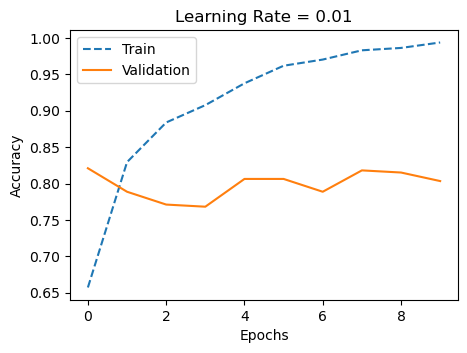

In [23]:
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

plt.figure(figsize=(5,3.5))
plt.plot(range(len(train_acc)), train_acc, '--', label='Train')
plt.plot(range(len(val_acc)), val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Rate = {}'.format(learning_rate))
plt.show()

The model is overfitting, as it reaches 99.5% accuracy in the training set, and 83% in the validation set. To avoid that, we should tune the learning rate parameter. To facilitate the process, let's write a function to create a neural network and train it, and another function to plot the train and validation accuracies.

In [20]:
def make_model(learning_rate):
    base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"],
    )
    
    return model


def plot_accuracy(train_accuracy, val_accuracy, title):
    plt.figure(figsize=(5,3.5))
    plt.plot(range(len(train_accuracy)), train_accuracy, '--', label='Train')
    plt.plot(range(len(val_accuracy)), val_accuracy, label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

In [16]:
lr_1 = 0.001
model_1 = make_model(learning_rate=lr_1)
model_1.fit(train_ds,
            epochs=10,
            validation_data=val_ds
           )

Epoch 1/10
96/96 [==============================] - 14s 128ms/step - loss: 1.1206 - accuracy: 0.6226 - val_loss: 0.7233 - val_accuracy: 0.7683
Epoch 2/10
96/96 [==============================] - 11s 118ms/step - loss: 0.6351 - accuracy: 0.7819 - val_loss: 0.6443 - val_accuracy: 0.8006
Epoch 3/10
96/96 [==============================] - 11s 119ms/step - loss: 0.5204 - accuracy: 0.8276 - val_loss: 0.5828 - val_accuracy: 0.8182
Epoch 4/10
96/96 [==============================] - 12s 121ms/step - loss: 0.4340 - accuracy: 0.8589 - val_loss: 0.5555 - val_accuracy: 0.8270
Epoch 5/10
96/96 [==============================] - 11s 119ms/step - loss: 0.3770 - accuracy: 0.8869 - val_loss: 0.5747 - val_accuracy: 0.8152
Epoch 6/10
96/96 [==============================] - 12s 120ms/step - loss: 0.3301 - accuracy: 0.9042 - val_loss: 0.5508 - val_accuracy: 0.8240
Epoch 7/10
96/96 [==============================] - 11s 119ms/step - loss: 0.2971 - accuracy: 0.9182 - val_loss: 0.5563 - val_accuracy: 0.7947

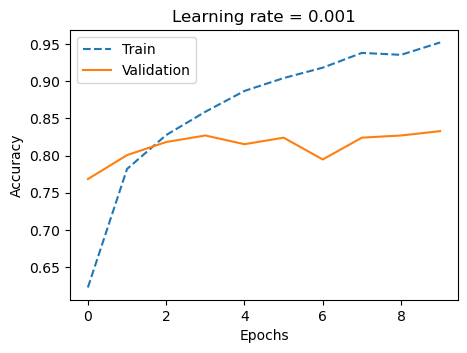

In [24]:
train_acc_1 = model_1.history.history['accuracy']
val_acc_1 = model_1.history.history['val_accuracy']

plot_accuracy(train_acc_1, val_acc_1, title="Learning rate = {}".format(lr_1))

In [18]:
lr_2 = 0.0001
model_2 = make_model(learning_rate=lr_2)
model_2.fit(train_ds,
            epochs=10,
            validation_data=val_ds
           )

Epoch 1/10
96/96 [==============================] - 14s 127ms/step - loss: 1.9034 - accuracy: 0.3722 - val_loss: 1.6040 - val_accuracy: 0.4692
Epoch 2/10
96/96 [==============================] - 11s 119ms/step - loss: 1.3745 - accuracy: 0.5671 - val_loss: 1.2667 - val_accuracy: 0.5806
Epoch 3/10
96/96 [==============================] - 12s 120ms/step - loss: 1.1294 - accuracy: 0.6431 - val_loss: 1.0807 - val_accuracy: 0.6657
Epoch 4/10
96/96 [==============================] - 12s 120ms/step - loss: 0.9877 - accuracy: 0.6799 - val_loss: 0.9691 - val_accuracy: 0.6979
Epoch 5/10
96/96 [==============================] - 11s 119ms/step - loss: 0.8942 - accuracy: 0.7141 - val_loss: 0.8967 - val_accuracy: 0.7273
Epoch 6/10
96/96 [==============================] - 11s 119ms/step - loss: 0.8268 - accuracy: 0.7344 - val_loss: 0.8465 - val_accuracy: 0.7390
Epoch 7/10
96/96 [==============================] - 12s 120ms/step - loss: 0.7744 - accuracy: 0.7477 - val_loss: 0.8044 - val_accuracy: 0.7713

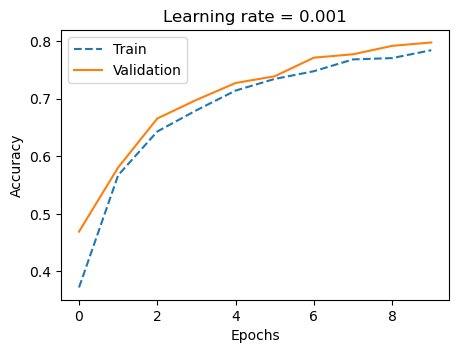

In [26]:
train_acc_2 = model_2.history.history['accuracy']
val_acc_2 = model_2.history.history['val_accuracy']

plot_accuracy(train_acc_2, val_acc_2, title="Learning rate = {}".format(lr_1))

Let's plot all accuracies together:

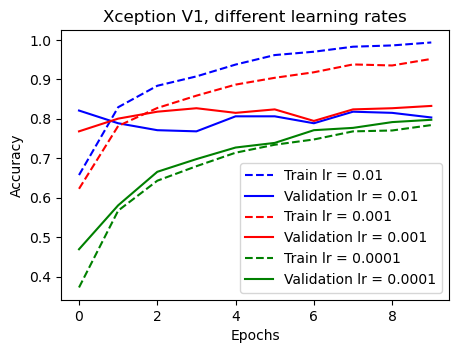

In [35]:
epochs = range(len(train_accuracy))

plt.figure(figsize=(5,3.5))
plt.plot(epochs, train_acc, '--', color='b', label='Train lr = {}'.format(learning_rate))
plt.plot(epochs, val_acc, color='b', label='Validation lr = {}'.format(learning_rate))
plt.plot(epochs, train_acc_1, '--', color='r', label='Train lr = {}'.format(lr_1))
plt.plot(epochs, val_acc_1, color='r', label='Validation lr = {}'.format(lr_1))
plt.plot(epochs, train_acc_2, '--', color='g', label='Train lr = {}'.format(lr_2))
plt.plot(epochs, val_acc_2, color='g', label='Validation lr = {}'.format(lr_2))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Xception V1, different learning rates')
plt.show()

The model that achieves the best validation accuracy is that with learning_rate = 0.001, so we are going to choose it. Although its validation accuracy is slightly better than that of learning_rate = 0.01, but for 0.01 the model overfits to the training dataset a lot faster, reaching a training accuracy of almost 100%. 

Now, let's see how we can save our best model. 

## Saving the best model
To avoid consuming disk space, let's use callback to save model with the number of epochs that yields the best validation accuracy.

In [38]:
# creating a callback 
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy")

model_best = make_model(learning_rate=lr_1)
model_best.fit(train_ds,
               epochs=10,
               validation_data=val_ds,
               callbacks=[checkpoint])

Epoch 1/10
96/96 [==============================] - 15s 132ms/step - loss: 1.0740 - accuracy: 0.6353 - val_loss: 0.7053 - val_accuracy: 0.7918
Epoch 2/10
96/96 [==============================] - 12s 125ms/step - loss: 0.6273 - accuracy: 0.7917 - val_loss: 0.6165 - val_accuracy: 0.8123
Epoch 3/10
96/96 [==============================] - 12s 120ms/step - loss: 0.5012 - accuracy: 0.8318 - val_loss: 0.5727 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 12s 123ms/step - loss: 0.4242 - accuracy: 0.8654 - val_loss: 0.5571 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 12s 121ms/step - loss: 0.3729 - accuracy: 0.8895 - val_loss: 0.5532 - val_accuracy: 0.8006
Epoch 6/10
96/96 [==============================] - 12s 126ms/step - loss: 0.3298 - accuracy: 0.9055 - val_loss: 0.5343 - val_accuracy: 0.8299
Epoch 7/10
96/96 [==============================] - 12s 121ms/step - loss: 0.2868 - accuracy: 0.9201 - val_loss: 0.5218 - val_accuracy: 0.8211

Now, looking at the specified directory, we can see that some models were saved.

## Enhancing the model: Adding more layers, and Dropout
We can add more layers to the model and see if it improves the performance.

Also, we can implement a special regularization technique called dropout. The main idea behind dropout is freezing a part of a dense layer when training. At each iteration, the part to freeze is chosen randomly. Only the unfrozen part is trained, and the frozen part is not touched at all.

If some parts of the network are ignored, the model overall is less likely to ovefit. When the network goes over a batch of images, the frozen part of a layer doesn’t see this data — it’s turned off. This way, it’s more difficult for the network to memorize the images. The code block for doing that will be like this:

```python
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
inner = keras.layers.Dense(100, activation='relu')(vector) # Here we use ReLU activation function instead of sigmoid
drop = keras.layers.Dropout(0.2)(inner) # Dropout layer
outputs = keras.layers.Dense(10)(drop) # Output layer

model = keras.Model(inputs, outputs)
```

Now, we let's update the `make_model` function to include this new neural network architecture and a new parameter to control the dropping rate.

In [40]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
        )
    
    return model

In [42]:
dr_0 = 0.0 # Drop rate

model_dr_0 = make_model(learning_rate=0.001, droprate=dr_0) 
model_dr_0.fit(train_ds, epochs=30, validation_data=val_ds) 

Epoch 1/30
96/96 [==============================] - 15s 130ms/step - loss: 0.9718 - accuracy: 0.6656 - val_loss: 0.6811 - val_accuracy: 0.7478
Epoch 2/30
96/96 [==============================] - 12s 121ms/step - loss: 0.5144 - accuracy: 0.8184 - val_loss: 0.5647 - val_accuracy: 0.7977
Epoch 3/30
96/96 [==============================] - 12s 123ms/step - loss: 0.3567 - accuracy: 0.8787 - val_loss: 0.5594 - val_accuracy: 0.8240
Epoch 4/30
96/96 [==============================] - 12s 122ms/step - loss: 0.2671 - accuracy: 0.9175 - val_loss: 0.5535 - val_accuracy: 0.8211
Epoch 5/30
96/96 [==============================] - 12s 122ms/step - loss: 0.1749 - accuracy: 0.9527 - val_loss: 0.5358 - val_accuracy: 0.8270
Epoch 6/30
96/96 [==============================] - 12s 121ms/step - loss: 0.1271 - accuracy: 0.9726 - val_loss: 0.6265 - val_accuracy: 0.8035
Epoch 7/30
96/96 [==============================] - 12s 122ms/step - loss: 0.1007 - accuracy: 0.9814 - val_loss: 0.5782 - val_accuracy: 0.8240

In [46]:
# Saving the train and validation accuracies
train_acc_0 = model_dr_0.history.history['accuracy']
val_acc_0 = model_dr_0.history.history['val_accuracy']

NameError: name 'model_dr_0' is not defined

In [43]:
dr_2 = 0.2 # Drop rate

model_dr_2 = make_model(learning_rate=0.001, droprate=dr_2) 
model_dr_2.fit(train_ds, epochs=30, validation_data=val_ds) 

Epoch 1/30
96/96 [==============================] - 15s 130ms/step - loss: 1.0933 - accuracy: 0.6444 - val_loss: 0.6755 - val_accuracy: 0.7947
Epoch 2/30
96/96 [==============================] - 12s 122ms/step - loss: 0.6292 - accuracy: 0.7826 - val_loss: 0.6553 - val_accuracy: 0.7859
Epoch 3/30
96/96 [==============================] - 12s 122ms/step - loss: 0.4760 - accuracy: 0.8325 - val_loss: 0.5672 - val_accuracy: 0.8006
Epoch 4/30
96/96 [==============================] - 12s 123ms/step - loss: 0.3695 - accuracy: 0.8722 - val_loss: 0.5478 - val_accuracy: 0.8152
Epoch 5/30
96/96 [==============================] - 12s 121ms/step - loss: 0.2931 - accuracy: 0.9022 - val_loss: 0.5313 - val_accuracy: 0.8152
Epoch 6/30
96/96 [==============================] - 12s 122ms/step - loss: 0.2392 - accuracy: 0.9218 - val_loss: 0.5951 - val_accuracy: 0.8094
Epoch 7/30
96/96 [==============================] - 12s 122ms/step - loss: 0.1984 - accuracy: 0.9371 - val_loss: 0.5764 - val_accuracy: 0.8299

In [45]:
# Saving the train and validation accuracies
train_acc_2 = model_dr_2.history.history['accuracy']
val_acc_2 = model_dr_2.history.history['val_accuracy']

In [49]:
dr_5 = 0.5 # Drop rate

model_dr_5 = make_model(learning_rate=0.001, droprate=dr_5) 
model_dr_5.fit(train_ds, epochs=30, validation_data=val_ds) 

Epoch 1/30
96/96 [==============================] - 15s 130ms/step - loss: 1.2903 - accuracy: 0.5763 - val_loss: 0.7565 - val_accuracy: 0.7566
Epoch 2/30
96/96 [==============================] - 12s 122ms/step - loss: 0.8497 - accuracy: 0.7115 - val_loss: 0.6902 - val_accuracy: 0.7859
Epoch 3/30
96/96 [==============================] - 12s 122ms/step - loss: 0.7087 - accuracy: 0.7510 - val_loss: 0.5852 - val_accuracy: 0.7947
Epoch 4/30
96/96 [==============================] - 12s 122ms/step - loss: 0.5943 - accuracy: 0.7947 - val_loss: 0.5687 - val_accuracy: 0.8123
Epoch 5/30
96/96 [==============================] - 12s 123ms/step - loss: 0.5108 - accuracy: 0.8276 - val_loss: 0.5532 - val_accuracy: 0.8123
Epoch 6/30
96/96 [==============================] - 12s 123ms/step - loss: 0.4640 - accuracy: 0.8351 - val_loss: 0.5673 - val_accuracy: 0.7947
Epoch 7/30
96/96 [==============================] - 12s 123ms/step - loss: 0.4083 - accuracy: 0.8553 - val_loss: 0.5224 - val_accuracy: 0.8211

In [54]:
# Saving the train and validation accuracies
train_acc_5 = model_dr_5.history.history['accuracy']
val_acc_5 = model_dr_5.history.history['val_accuracy']

In [50]:
dr_8 = 0.8 # Dropout rate

model_dr_8 = make_model(learning_rate=0.001, droprate=dr_8)
model_dr_8.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
96/96 [==============================] - 15s 130ms/step - loss: 1.8100 - accuracy: 0.3774 - val_loss: 1.1699 - val_accuracy: 0.6305
Epoch 2/30
96/96 [==============================] - 12s 121ms/step - loss: 1.4275 - accuracy: 0.4945 - val_loss: 0.9948 - val_accuracy: 0.7038
Epoch 3/30
96/96 [==============================] - 12s 122ms/step - loss: 1.2616 - accuracy: 0.5561 - val_loss: 0.8599 - val_accuracy: 0.7155
Epoch 4/30
96/96 [==============================] - 12s 122ms/step - loss: 1.1812 - accuracy: 0.5799 - val_loss: 0.8078 - val_accuracy: 0.7507
Epoch 5/30
96/96 [==============================] - 12s 122ms/step - loss: 1.1358 - accuracy: 0.5991 - val_loss: 0.7781 - val_accuracy: 0.7507
Epoch 6/30
96/96 [==============================] - 12s 122ms/step - loss: 1.0878 - accuracy: 0.6053 - val_loss: 0.7577 - val_accuracy: 0.7683
Epoch 7/30
96/96 [==============================] - 12s 122ms/step - loss: 1.0296 - accuracy: 0.6261 - val_loss: 0.7067 - val_accuracy: 0.7830

In [52]:
# Saving the train and validation accuracies
train_acc_8 = model_dr_8.history.history['accuracy']
val_acc_8 = model_dr_8.history.history['val_accuracy']

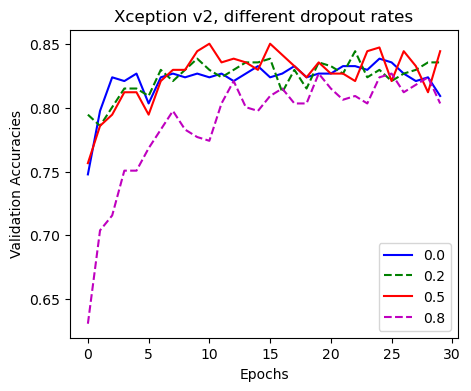

In [60]:
epochs = range(30)

plt.figure(figsize=(5,4))
plt.plot(epochs, val_acc_0, '-', color='b', label=dr_0)
plt.plot(epochs, val_acc_2, '--', color='g', label=dr_2)
plt.plot(epochs, val_acc_5, '-', color='r', label=dr_5)
plt.plot(epochs, val_acc_8, '--', color='m', label=dr_8)
plt.title('Xception v2, different dropout rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracies')
plt.legend()
plt.show()

The model takes longer to get good results with a dropout rate of 0.8.  As the performances for 0.0, 0.2 and 0.5 are very close to each other, it is good to also plot the training accuracies:

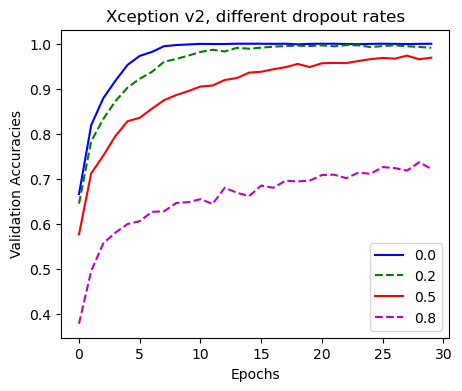

In [63]:
epochs = range(30)

plt.figure(figsize=(5,4))
plt.plot(epochs, train_acc_0, '-', color='b', label=dr_0)
plt.plot(epochs, train_acc_2, '--', color='g', label=dr_2)
plt.plot(epochs, train_acc_5, '-', color='r', label=dr_5)
plt.plot(epochs, train_acc_8, '--', color='m', label=dr_8)
plt.title('Xception v2, different dropout rates')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracies')
plt.legend()
plt.show()

The dropout rate of 0.5 is less prone to overfitting, so we are going to choose this value.

## Data Augmentation
Surely, the best way to avoid overfitting is to get more data. However, this isn't always possible: we have to work with the data we are given. But for images, it is possible to use a technique called data augmentation, where we generate more images from existing images, using transformations like:
- Flip an image vertically and horizontally;
- Rotate an image;
- Zoom in or out a bit;
- And change an image in other ways.  

In Keras, there’s a built-in way for augmenting a dataset. It’s based on ``ImageDataGenerator``, which we have already used for reading the images.

In [66]:
train_gen = ImageDataGenerator(
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
)

# Train dataset augmented 
train_ds_aug = train_gen.flow_from_directory(
    "../data/clothing-dataset-small/train",
    target_size=(150, 150),
    batch_size=32,
)

Found 3068 images belonging to 10 classes.


In [69]:
model_best_aug = make_model(learning_rate=0.001, droprate=0.5)
model_best_aug.fit(train_ds_aug, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 [==============================] - 27s 263ms/step - loss: 1.3810 - accuracy: 0.5411 - val_loss: 0.7951 - val_accuracy: 0.7507
Epoch 2/50
96/96 [==============================] - 24s 246ms/step - loss: 0.9205 - accuracy: 0.6890 - val_loss: 0.6546 - val_accuracy: 0.7889
Epoch 3/50
96/96 [==============================] - 24s 246ms/step - loss: 0.7945 - accuracy: 0.7311 - val_loss: 0.6179 - val_accuracy: 0.8006
Epoch 4/50
96/96 [==============================] - 24s 246ms/step - loss: 0.7020 - accuracy: 0.7559 - val_loss: 0.5926 - val_accuracy: 0.8094
Epoch 5/50
96/96 [==============================] - 24s 246ms/step - loss: 0.6647 - accuracy: 0.7705 - val_loss: 0.5939 - val_accuracy: 0.7918
Epoch 6/50
96/96 [==============================] - 24s 246ms/step - loss: 0.6245 - accuracy: 0.7898 - val_loss: 0.5769 - val_accuracy: 0.7947
Epoch 7/50
96/96 [==============================] - 24s 245ms/step - loss: 0.6115 - accuracy: 0.7859 - val_loss: 0.5469 - val_accuracy: 0.8152

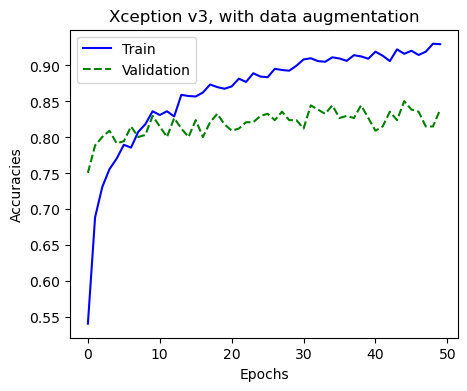

In [72]:
# Saving the train and validation accuracies
train_acc_aug = model_best_aug.history.history['accuracy']
val_acc_aug = model_best_aug.history.history['val_accuracy']

# Plotting the results
epochs = range(50)

plt.figure(figsize=(5,4))
plt.plot(epochs, train_acc_aug, '-', color='b', label='Train')
plt.plot(epochs, val_acc_aug, '--', color='g', label='Validation')
plt.title('Xception v3, with data augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.show()

With around 20 epochs, the model reaches a saturation point in the training set, so this number of epochs should be enough. 

## Training a larger model
Now that we analyzed the neural network architecture and found the best parameters, we can train a larger model that gets images with a size of 299x299 instead of only 150x150. This will allow the network to perceive more details about the images, improving its performance. However, the training will take longer to finish, so be prepared to wait. 

First, we need to modify the `make_model` function to accept the 299x299 sized images:

In [73]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
        )
    
    return model

In [74]:
# Train dataset augmented and with new size
train_ds_size = train_gen.flow_from_directory(
    "../data/clothing-dataset-small/train",
    target_size=(299, 299),
    batch_size=32,
)

# Validation dataset with new size
val_ds_size = validation_gen.flow_from_directory(
    "../data/clothing-dataset-small/validation",
    target_size=(299, 299),
    batch_size=32,
)

# creating a callback 
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy")

model_final = make_model(learning_rate=0.001, droprate=0.5)
model_final.fit(train_ds_size, 
                epochs=20, 
                validation_data=val_ds_size,
                callbacks=[checkpoint])

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Epoch 1/20
96/96 [==============================] - 68s 671ms/step - loss: 1.0018 - accuracy: 0.6757 - val_loss: 0.5165 - val_accuracy: 0.8299
Epoch 2/20
96/96 [==============================] - 63s 654ms/step - loss: 0.5766 - accuracy: 0.8008 - val_loss: 0.4250 - val_accuracy: 0.8592
Epoch 3/20
96/96 [==============================] - 63s 652ms/step - loss: 0.4890 - accuracy: 0.8321 - val_loss: 0.4012 - val_accuracy: 0.8534
Epoch 4/20
96/96 [==============================] - 63s 651ms/step - loss: 0.4500 - accuracy: 0.8442 - val_loss: 0.3916 - val_accuracy: 0.8710
Epoch 5/20
96/96 [==============================] - 63s 651ms/step - loss: 0.4150 - accuracy: 0.8563 - val_loss: 0.3501 - val_accuracy: 0.8856
Epoch 6/20
96/96 [==============================] - 63s 657ms/step - loss: 0.3819 - accuracy: 0.8709 - val_loss: 0.3612 - val_accuracy: 0.8827
Epoch 7/20
96/96 [==============================] - 62s 6

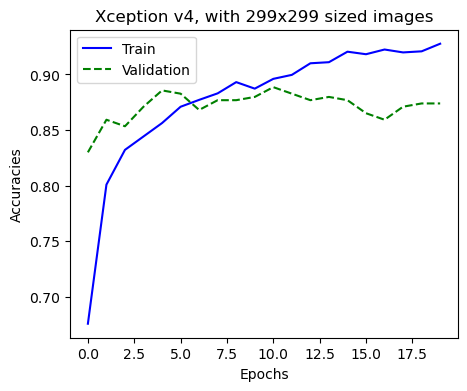

In [77]:
# Saving the train and validation accuracies
train_acc_final = model_final.history.history['accuracy']
val_acc_final = model_final.history.history['val_accuracy']

# Plotting the results
epochs = range(20)

plt.figure(figsize=(5,4))
plt.plot(epochs, train_acc_final, '-', color='b', label='Train')
plt.plot(epochs, val_acc_final, '--', color='g', label='Validation')
plt.title('Xception v4, with 299x299 sized images')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.show()

## Using the model
Now that we have a trained model and saved it, let's use it to make predictions. 

For educational purposes, we are going to load the model we just trained and use it. 

In [78]:
# Loading the model
model_loaded = keras.models.load_model('xception_v4_11_0.889.h5')

# Creating the test dataset
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_ds = test_gen.flow_from_directory(
    "../data/clothing-dataset-small/test",
    shuffle=False,
    target_size=(299, 299),
    batch_size=32,
)

# Evaluting the loaded model
model_loaded.evaluate(test_ds)

Found 372 images belonging to 10 classes.
12/12 [==============================] - 4s 278ms/step - loss: 0.2902 - accuracy: 0.9032


[0.29017871618270874, 0.9032257795333862]

The model has an accuracy of 90% on the test dataset, which is pretty good.

### Predicting a single image
If we want to use the model to predict a single image, that is quite simple. First, we load the image, preprocess it, and then use the `.predict` method to get a prediction. 

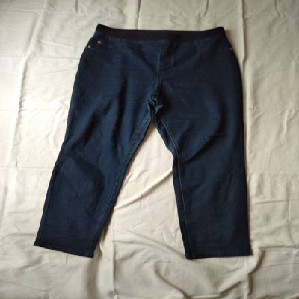

In [79]:
# Loading a single imagem
path = '../data/clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(299, 299))

img

In [82]:
# Preprocessing the image
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model_final.predict(X)
pred[0]

1/1 [==============================] - 0s 22ms/step


array([-4.2048793, -6.2546186, -3.1386676, -6.5759163, 11.574557 ,
       -3.9434319, -5.4426646,  5.424705 , -5.0698547, -6.7837367],
      dtype=float32)

The model outputs a list of probabilities, with each one corresponding to a class. To make a readable prediction, we need to create a mapping of classes and cloth types:

In [83]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

Now, to get the prediction, we should just run the line below:

In [84]:
labels[pred[0].argmax()]

'pants'

Let's try with another image from the test set.

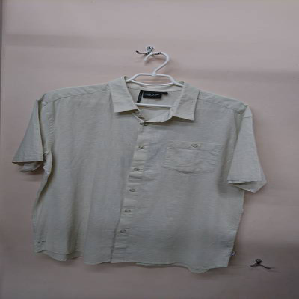

In [86]:
# Loading a single imagem
path = '../data/clothing-dataset-small/test/shirt/45814191-3d17-486c-8883-8ddd97b3e7f7.jpg'
img = load_img(path, target_size=(299, 299))

img

In [88]:
# Preprocessing the image
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model_final.predict(X)
print(labels[pred[0].argmax()])

1/1 [==============================] - 0s 23ms/step
shirt


That's correct!